In [1]:
# inputs

#run reduce funciton

#load data and plot

#load data and do IRF or step fit

#load data and do gausian fitting (lensh/lensv)

#Stack data

# inputs

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcsx51920'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/smd_Beamtime/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/ReducedData/'
outpath='/reg/d/psdm/xcs/'+exper+'/scratch/slr/'
# outpath='/cds/home/s/slraj/code/ScatteringCode/'


Import Complete!


## set up varDict

In [3]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        # 'ttFLTPOS_PS'   : 'tt/FLTPOS_PS', ## in picoseconds
        # 'ttREFAMPL'     : 'tt/REFAMPL',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 
        # 'lxt_ttc'       : 'epics/lxt_ttc',
        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    
        ## scattering detector error
        #'azav_sqr'     :  'epix10k2M/azav_azav_square',
        # 'pix_per_azav'  :  'UserDataCfg/epix10k2M/azav__azav_norm',
    
        # ## spectroscopy variables
        # 'epix_roi0'        : 'epix_1/ROI_0_area',
        # 'epix_roi0_sum'    : 'epix_1/ROI_0_sum',
        # 'droplet_x'        : 'epix_1/ragged_droplet_photon_j', #nondispersive axis
        # 'droplet_y'        :  'epix_1/ragged_droplet_photon_i', #energy dispersive
        # 'epix_roi0_limits' : 'UserDataCfg/epix_1/ROI_0__ROI_0_ROI',

        }

## set up paramDict

In [4]:
setbins=np.arange(-0.5e-12,1e-12,.01e-12)


paramDict= {
        'binSetup'  : 'fixed',
        'binSet2'   : setbins,
        'binMethod' : 'ave', 
        'qnorm'     : (2.5,3), 
        'qrange'    : (0.8,3.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 4, # select ipm to use
        'corr_filter' : True,
        'corr_threshold': 50 , #threshold for 
        'ipm_filter' : (10000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 100, #lower limit for Iscat
    
        'use_TT'   :  True,  #options are True, False, and 'filter'  ('filter is for filtering only) 
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : False, # ebeam photon energy correction
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,
    
        'showSVD': True, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot':None, #how to slice up plots displayed at end
        'smooth':None, #smoothinng before svd?
        
        'overwrite' : True, # overwrite files? 
        'save_mat'  : True,
    
    }

In [ ]:
### for lens or power scans
v2={'scan_vec'      : 'scan/var0',
   }


p2={ 'binSetup'  : 'unique',
    'corr_filter' : False,
    
    'use_TT' : False, 
    'scan_var'  :None, 
   }

varDict.update(v2)
paramDict.update(p2)

# Run Reduction

loading  /reg/d/psdm/xcs/xcsx51920/hdf5/smalldata/smd_Beamtime/xcsx51920_Run0491.h5
scan variable is  newdelay
finished loading h5


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/SetUpFns.py:120: RuntimeWarning: Mean of empty slice
  Iscat=np.nanmean(azav_temp,(1,2)) #mean along 2 axes


calculated Iscat
setupFilters - done!
making correlation filter
correlation equation = 1.493007e-03 x +-6.796164e+01
fraction of data kept 6.297135e-01
TTFWHM: fraction_kept  0.9908639205000801  lower  112.76619685567132  upper  124.46358804672225
TTPOS: fraction_kept  0.9907073620123368  lower  382.1449958972534  upper  695.2491782982556
18.022531509399414  seconds
t=(encoder + tt/ttCorr)*1e-12


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:93: RuntimeWarning: Mean of empty slice
  darkMean = np.nanmean(dark,0)


x-ray off subtraction done!
normalize data


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/diffSignalTools.py:11: RuntimeWarning: Mean of empty slice
  az_av=np.nanmean(dat,1) #single azimuthal averages
/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/diffSignalTools.py:13: RuntimeWarning: Mean of empty slice
  norm_factor=np.nanmean(az_av[:,q_ind],1) #mean of points between q limits for each shot
/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:292: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(cspad_azav[early_x,:,:]/normal_factor[early_x,None,None],0) #normalize by norm


normalize data done!
starting difference signal
Difference Signal Done!
61.58156728744507  seconds
Starting binning
bin by given bins
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!
64.82339763641357  seconds
start anisotropy
shift is 32 degrees
149
148saved output to  /reg/d/psdm/xcs/xcsx51920/scratch/slr/npy/xcsx51920_Run0491_out.npy
plotting azavs
logscan False
(149, 883)
(883,)
plottingn aniso
(149, 11, 883)
(12,)
done
233.8465530872345  seconds


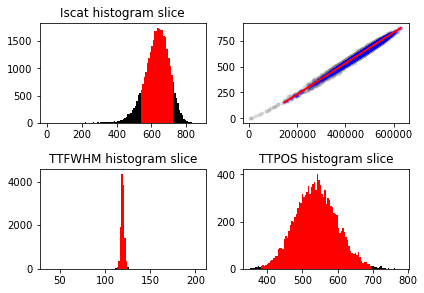

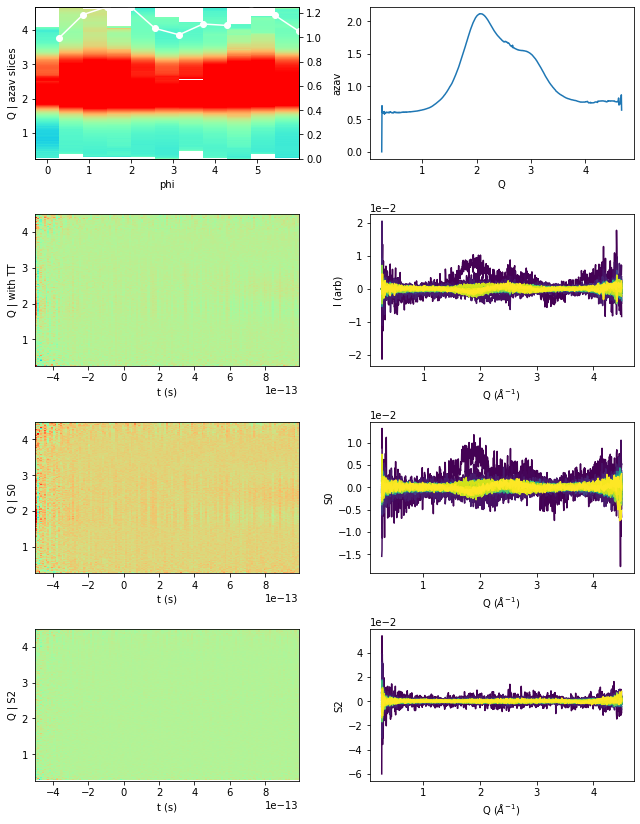

In [4]:
runs=[491]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Load Data and Plot

In [118]:
runnum=118
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum
# filepath=outpath+'/npy/'+exper+'_Run%04i_dat.npz' %runnum
# filepath='/cds/home/s/slraj/code/ScatteringCode/npy/xcsly3420_Run0120_out.npy'

try:
    data= np.load(filepath,allow_pickle= True).item()
except: 
    data= np.load(filepath,allow_pickle= True)['arr_0'].item()
qs=data['qs']
phis=data['phis']
try:
    ts=data['xcenter']
except:
    ts=data['ts']
diff=data['diff_bin']
try:
    S0=data['S0']
    S2=data['S2']
except:
    print('no aniso')

## do anisotropy

In [90]:
S0, err_S0, S2, err_S2=S0S2(diff,phis,fil=None,shift_n=0,deg=None)

shift is 0 degrees
11
10

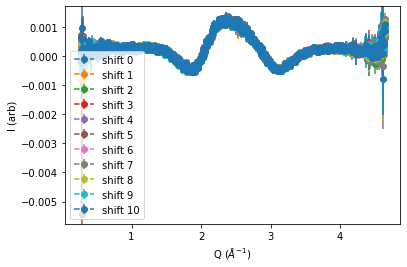

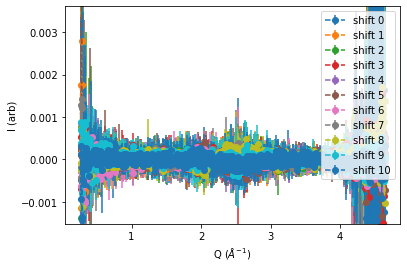

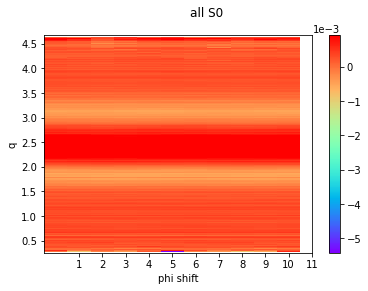

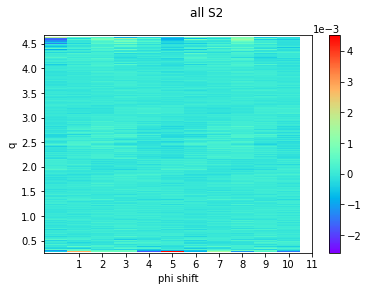

In [37]:
all_S0, all_S2=S0S2_check(diff,qs,phis,trange='All',lim=None,calc2=False)

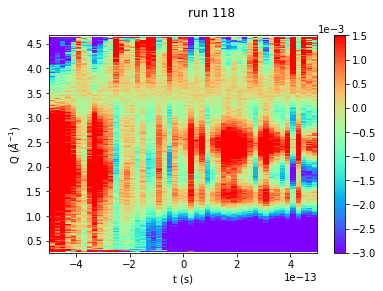

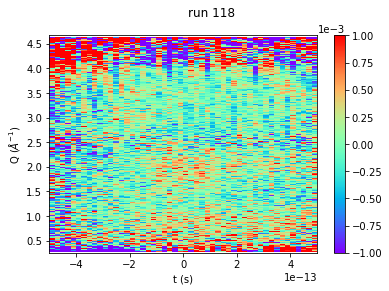

In [120]:
trange=(-.5e-12,.5e-12)
goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
plot_2d(ts[goodt],qs,S0[goodt,:].squeeze(),ccmap='rainbow')
plt.suptitle('run %i'%runnum)
plt.clim(-3e-3,1.5e-3)

# trange=(-0.5e-12,0.5e-12)
goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
plot_2d(ts[goodt],qs,S2[goodt,:].squeeze(),ccmap='rainbow')
plt.suptitle('run %i'%runnum)
plt.clim(-1.e-3,1.e-3)

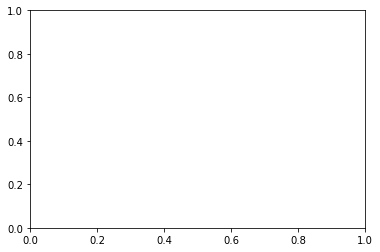

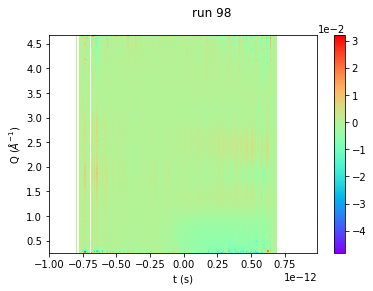

In [77]:
try:
    trange=(.05e-9,.08e-9)
    goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
    plot_2d(ts[goodt],qs,np.nanmean(diff,axis=1)[goodt,:].squeeze(),ccmap='rainbow')
    plt.suptitle('run %i'%runnum)
    # plt.xlabel('phis (rad)')

except:
    plot_2d(ts,qs,np.nanmean(diff,axis=1),ccmap='rainbow')
    plt.suptitle('run %i'%runnum)

# Load Data and Fit Gaussian

In [6]:
def gaus(x, a, b, c, d):
    return a * np.exp(-1*(x-b)**2/2/c**2) + d

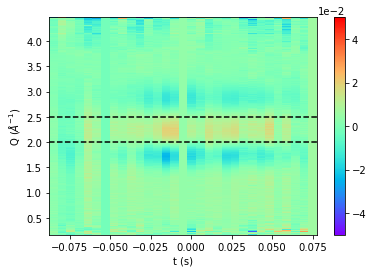

In [23]:
## fit q vs lens_h with gaussian and extract fwhm 
runnum=22
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum
# filepath=outpath+'/npy/'+exper+'_Run%04i_dat.npz' %runnum
# filepath='/cds/home/s/slraj/code/ScatteringCode/npy/xcsly3420_Run0120_out.npy'
qrange=(2,2.5)            
try:
    data= np.load(filepath,allow_pickle= True).item()
except:
    data= np.load(filepath,allow_pickle= True)['arr_0'].item()
qs=data['qs']
phis=data['phis'][0:-1]
try:
    scanvar=data['ts']
except:
    scanvar=data['xcenter']
diff=data['diff_bin']

goodq = np.where((qs > qrange[0]) & (qs < qrange[1]))[0]
diff2d=np.nanmean(diff,1)#average over phis
plt.figure('scanvar2')
plot_2d(scanvar,qs,diff2d,fig='scanvar2')
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
plt.clim(-5e-2,5e-2)
diff1d=np.nanmean(diff2d[:,goodq],1)

In [1]:

lens_v=True
lens_v=False

if lens_v:
    p0=[.005,.05,.05,0.001] #lensv
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

    center=param[1]
    fwhm=param[2]*2.355
    
else:
    p0=[.006,.0,0.01,-0.001]
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

#     param, err =curve_fit(gaus,scanvar,diff1d)

center=param[1]
fwhm=param[2]*2.355

plt.figure('fit')
plt.plot(scanvar,diff1d,'k')
plt.plot(scanvar,gaus(scanvar,*param),'r',label='fit')
if lens_v:
    plt.xlabel('lens_v')
else:
    plt.xlabel('lens_h')
plt.ylabel('diff')
plt.legend()
plt.suptitle(('run=',runnum,'center=',center,'fwhm=',fwhm,'qrange',qrange))

NameError: name 'curve_fit' is not defined

# Load Data and Fit Rise

In [16]:
from scipy.special import erf

def stepfn(x, A,x0,sigma,B):
    return (A/2*erf((x0-x)/sigma)+B)

dict_keys(['h5name', 'numshots', 'filters', 'normal_factor', 'loff_cake', 'xbin_occupancy', 'xcenter', 'xmean', 'xstd', 'diff_bin', 'diff_std', 'S0', 'S0_err', 'S2', 'S2_err', 'qs', 'phis', 'paramDict', 'numshots_used'])


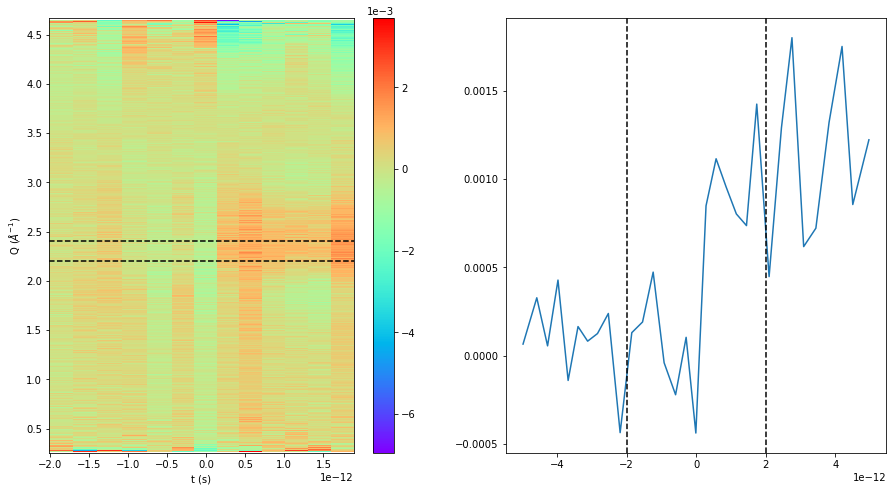

In [14]:
runnum=62
qrange=(2.2,2.4)
trange=(-2e-12,2e-12)

filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum
# filepath='/reg/d/psdm/xcs/xcsx51920/results/ReferenceData/xpp00316_water_data.npy'

data= np.load(filepath,allow_pickle= True).item()
print(data.keys())

qs=data['qs']
ts=data['xcenter']
# S2=data['S2']
S2=data['S0']

# qs=data['q'].squeeze()
# ts=data['Delays'].squeeze()
# S2=data['AllTTDelayS2'].T


goodq=np.nonzero((qrange[0]<qs) & (qs<qrange[1]))
S2slice=np.nanmean(S2[:,goodq].squeeze(),axis=1)
# S2slice=np.nansum(S2[:,goodq].squeeze(),axis=1)

goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
S2slice2=S2slice[goodt].squeeze()

plt.figure('S2slice1',figsize=(15,8))
plot_2d(ts[goodt].squeeze(),qs,S2[goodt,:].squeeze(),fig='S2slice1',sub=121)
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
# plt.xlabel('lxe_opa')


plt.subplot(122)
plt.plot(ts,S2slice)
# plt.xlabel('lxe_opa')
plt.axvline(trange[0],ls='--',color='k')
plt.axvline(trange[1],ls='--',color='k')


x0= 0.0 fwhm 0.1884


/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.8/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


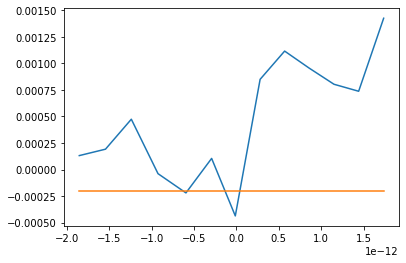

In [19]:

p0=[0.002,0,.08,-.0002] #initial guesses
param, err =curve_fit(stepfn,ts[goodt].squeeze(),S2slice2,p0=p0)

center=param[1]
fwhm=param[2]*2.355
print('x0=',center,'fwhm',fwhm)


plt.figure('fit')
plt.plot(ts[goodt],S2slice2)
plt.plot(ts[goodt],stepfn(ts[goodt],*param),label='fit')


# Load Data and Fit IRF

In [33]:
runnum=71
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum
# filepath='/cds/home/s/slraj/code/ScatteringCode/npy/xcsly3420_Run0120_out.npy'
# filepath='/reg/d/psdm/xcs/xcsx51920/results/ReferenceData/xpp00316_water_data.npy'       

data= np.load(filepath,allow_pickle= True).item()
print(data.keys())
qs=data['qs']
ts=data['xcenter']*1e12
S2=data['S2']

# qs=data['q'].squeeze()
# ts=data['Delays'].squeeze()
# S2=data['AllTTDelayS2'].T


### load Castner reference OKE data####
Castner=np.loadtxt('/cds/home/s/slraj/code/tools/ReferenceData/Castner1995figure4.dat',skiprows=3)
print('Castner trange (ps)',np.nanmin(Castner[:,0]),np.nanmax(Castner[:,0]))

dict_keys(['h5name', 'numshots', 'filters', 'normal_factor', 'loff_cake', 'xbin_occupancy', 'xcenter', 'xmean', 'xstd', 'diff_bin', 'diff_std', 'S0', 'S0_err', 'S2', 'S2_err', 'qs', 'phis', 'paramDict', 'numshots_used'])
Castner trange (ps) 0.0 6.8279934


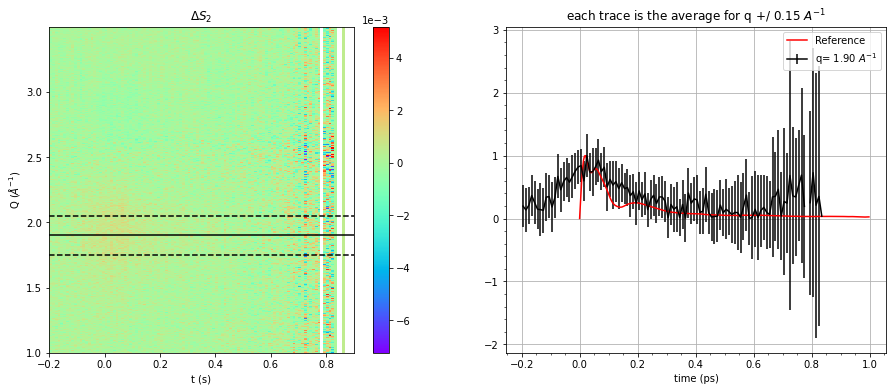

In [37]:
qCenter=1.9
qWidth=0.15
trange=(-.2,0.9)
qrange=(1.0,3.5)

S2slice,S2slice_std=IRFprep(S2,qs=qs,ts=ts,ref=Castner[:300,1],tref=Castner[:300,0],
            qCenter=qCenter,qWidth=qWidth,
            trange=trange,qrange=qrange)

chiAll shape (1190, 500)
starting calculation
finished calculation
chi min 0.0512 sigma [0.0627] fwhm [0.1476585] tt0 [0.197]


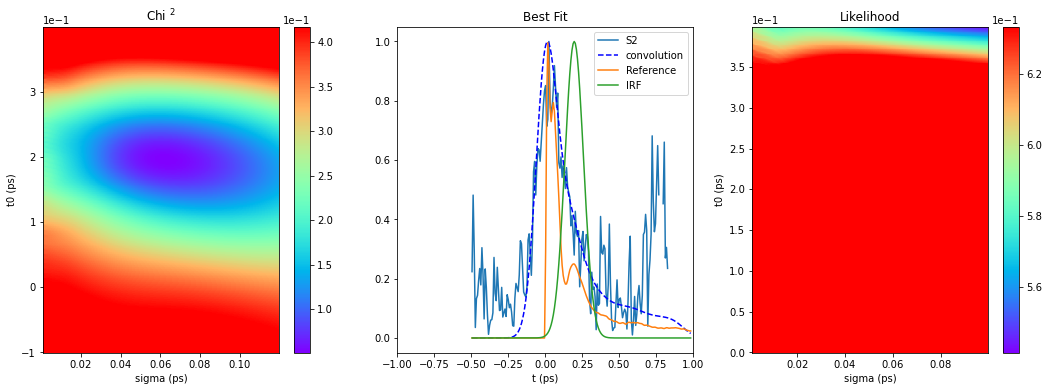

In [35]:
sigmaL=np.arange(0.001,0.12,0.0001)
tt0L=np.arange(-0.1,0.4,0.001)
trange=(-.4,0.9)

chiAll,likeAll=doIRFfit(S2slice,S2slice_std,qs=qs,ts=ts,ref=Castner[:300,1],tref=Castner[:300,0],
                        tt0L=tt0L,sigmaL=sigmaL,trange=trange)

# Stack Runs 

In [47]:
runpath=outpath+'npy/'
runs2=[71,72]

stackDict=StackProccessed(runpath,exper,runs2,method='bincount')

In [18]:
## save stack
outname=exper+'Stack_65_to_70'

np.save(outpath+'/stack_npy/'+outname+'.npy',stackDict)

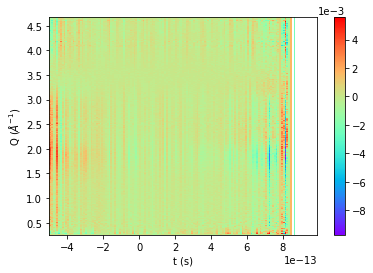

In [49]:
plot_2d(ts,qs,np.nanmean(diff,1).T)

In [58]:

print(stackDict.keys())
diff=stackDict['aveData']
ts=stackDict['ts']
qs=stackDict['qs']
phis=stackDict['phis']

# S0, err_S0, S2, err_S2=S0S2(diff,phis,fil=None,shift_n=1,deg=None)
# outdict=SnFitT(2,diff,qs,phis[:-1],1.3051,shift_n=1)

dict_keys(['aveData', 'sumBC', 'ts', 'qs', 'phis', 'runs', 'method'])
shift is 32 degrees
149
0

ValueError: cannot convert float NaN to integer

In [55]:
outdict.keys()

S2=outdict['Sn'][:,:,0]

In [25]:
outdict['Sn'].shape

(99, 883, 2)

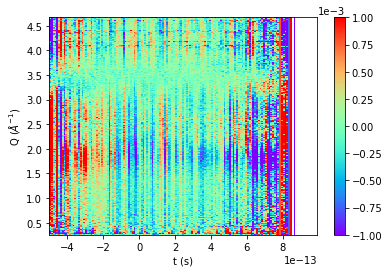

In [57]:
plot_2d(ts,qs,S2)
plt.clim(-1e-3,1e-3)

# Check h5

In [66]:
run = 23
smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'

fname=smalldata_folder+ exper+'_Run%04i.h5'%run


with h5py.File(fname, 'r') as d:
    pp='epix_1'
    # pp=''
    # pp='/diodeGon/'
    
    for a in d[pp]:
        try: 
            print(a,d[pp][a][:].shape)
        except:
            print(a)
      
    
    lxt=d['epics/lxt'][:]
    lxt_fast=d['enc/lasDelay'][:]
    laserP=d['/diodeGon/channels/'][:,0]
    filterP = laserP>(np.nanmean(laserP)-np.nanstd(laserP)*3)
    # dropx=d['epix_1/ragged_droplet_photon_i'][:]
    # lxe_opa=d['scan/lxe_opa'][:]
    # var0=d['scan/var0'][:]
    # varStep=d['scan/varStep'][:]
    print('okay','\n')
    print(d['ebeam/photon_energy'][0])
    # print(d['UserDataCfg/epix10k2M/azav__azav_qbins'].shape)
    # ttCorr=d['tt/ttCorr'][:]
    # fltpos=d['tt/FLTPOS'][:]


    # azav=d['epix10k2M/azav_azav'][:]
    # ipm4=d['ipm4/sum'][:]
    # ipm5=d['ipm4/sum'][:]
    # ImSum=d['Sums/epix10k2M_calib'][:]
    # Npix=d['UserDataCfg/epix10k2M/azav__azav_Cake_Npixel'][:]
    # qs=d['UserDataCfg/epix10k2M/azav__azav_q'][:]
    # phis=d['UserDataCfg/epix10k2M/azav__azav_phiVec'][:]

    # Isum=np.nanmean(azav,(1,2))
# pos=np.array([xx,yy])


ROI_0_area (18691, 704, 768)
ROI_0_com (18691, 2)
ROI_0_max (18691,)
ROI_0_mean (18691,)
ROI_0_sum (18691,)
okay 

9609.90675037739


In [71]:
lxt_fast

array([53.37840556, 53.37840556, 53.37840556, ..., 53.37840556,
       53.37840556, 53.37840556])